# 04. PyTorch Custom Datasets

How to get your own data into PyTorch

One of the ways to do so is via custom datasets.

## Domain libraries

Depending on what you're working on: vision, text, audio, recommendation... You'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 has 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (75 training, 25 testing).
The preparation was already done by someone else, but I'll have to analyze it lateeer.

Why only use the subset instead of the whole dataset?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole points is to speed up how fast you can experiment.


In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

image_path

WindowsPath('data/pizza_steak_sushi')

In [4]:
# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading the data...")
        f.write(request.content)
    
    # Unzip the file
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
        print("Unzipping the data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing images

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. Show the image and print the metadata

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get the paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick some random image paths
random_images = random.choices(image_path_list, k=4)

In [9]:
# 3. Get image class from path name
image_classes = [x.parent.stem for x in random_images]
image_classes

['steak', 'pizza', 'pizza', 'sushi']

Random image path: data\pizza_steak_sushi\train\steak\256592.jpg
Image class: steak
Image height: 384
Image width: 512


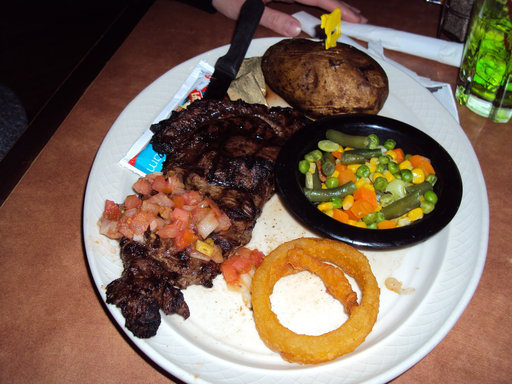

Random image path: data\pizza_steak_sushi\test\pizza\2019408.jpg
Image class: pizza
Image height: 512
Image width: 512


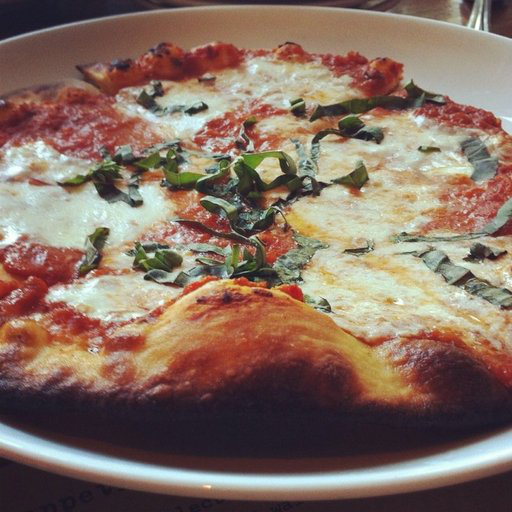

Random image path: data\pizza_steak_sushi\train\pizza\138855.jpg
Image class: pizza
Image height: 384
Image width: 512


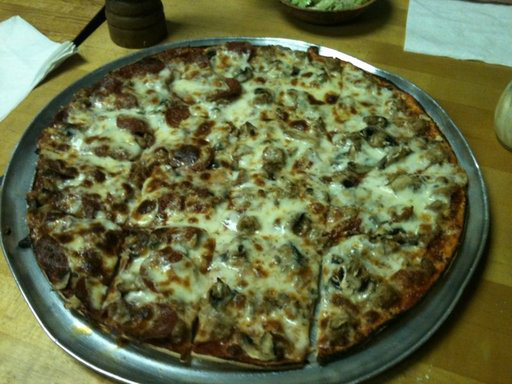

Random image path: data\pizza_steak_sushi\test\sushi\3837522.jpg
Image class: sushi
Image height: 512
Image width: 512


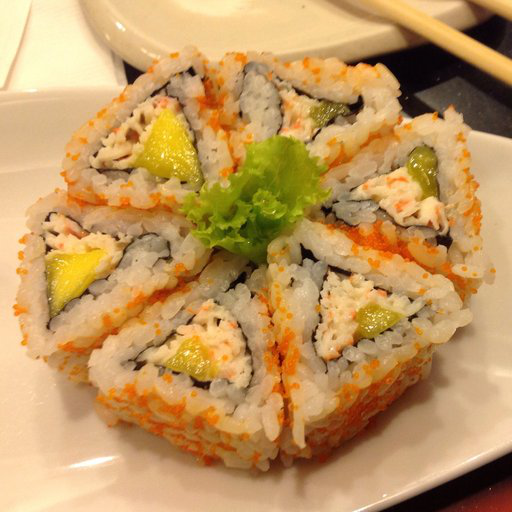

In [10]:
from IPython.display import display

# 4. Open image
imgs = [Image.open(img_path) for img_path in random_images]

# 5. Print metadata
for img_path, img_class, img in zip(random_images, image_classes, imgs):
    print(f"Random image path: {img_path}")
    print(f"Image class: {img_class}")
    print(f"Image height: {img.height}")
    print(f"Image width: {img.width}")
    display(img)


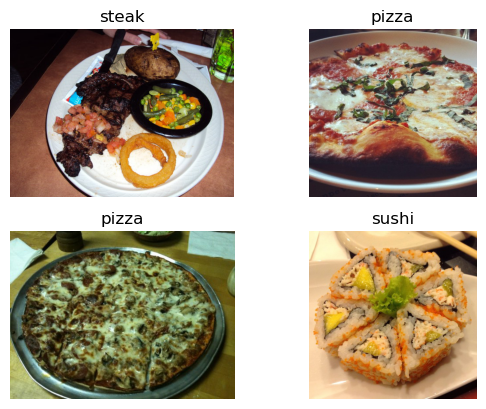

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for i, img in enumerate(imgs):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_classes[i])
plt.show()

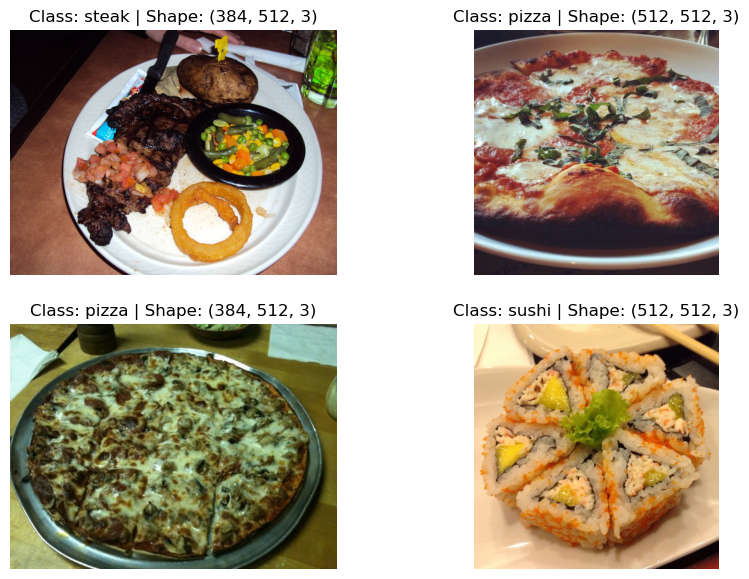

In [12]:
# Alternate version:

plt.figure(figsize=(10, 7))
for i, img in enumerate(imgs):
    # Turn the image into an array
    img_as_array = np.asarray(img)
    
    # Plot the image
    plt.subplot(2, 2, i+1)
    plt.imshow(img_as_array)
    plt.title(f"Class: {image_classes[i]} | Shape: {img_as_array.shape}")
    plt.axis('off')

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your input data into tensors (in our case, a numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` to make it easier to work with
3. 

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation.

In [14]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
data_transform(imgs[0]).shape

torch.Size([3, 64, 64])

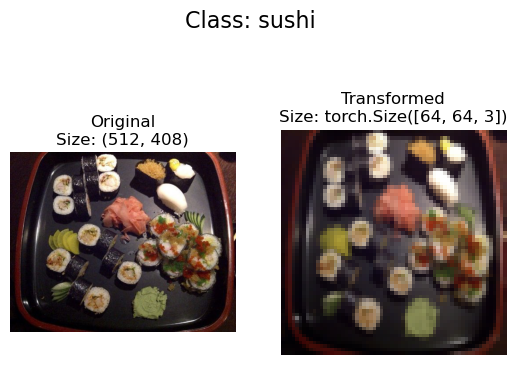

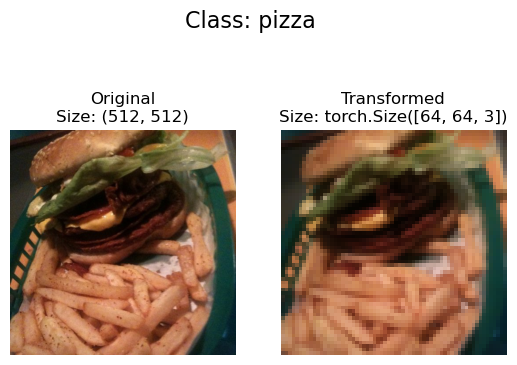

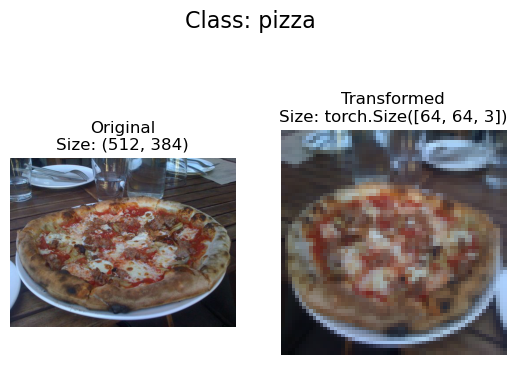

In [16]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms them
    then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis('off')

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # We need to change the path for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`.

We can load image classification data using `torchvision.datasets.ImageFolder`.

In [17]:
# Use Imagefolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names as list
class_names = train_data.classes
print(class_names)

# Get class names as dict
class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [21]:
# Index on the train_Data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img[0][:2][:2]

tensor([[0.1137, 0.1020, 0.0980, 0.1020, 0.1059, 0.0941, 0.0863, 0.0784, 0.0706,
         0.0510, 0.0078, 0.0039, 0.0039, 0.0078, 0.0118, 0.0118, 0.0118, 0.0118,
         0.0078, 0.0039, 0.0039, 0.0039, 0.0039, 0.0118, 0.0078, 0.0118, 0.0275,
         0.0392, 0.0118, 0.0078, 0.0078, 0.0078, 0.0118, 0.0196, 0.0118, 0.0078,
         0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0118, 0.0157, 0.0235,
         0.1098, 0.1686, 0.1961, 0.1647, 0.1373, 0.1294, 0.1294, 0.1255, 0.1255,
         0.1255, 0.1176, 0.1059, 0.1098, 0.1176, 0.1216, 0.1216, 0.1255, 0.1216,
         0.1176],
        [0.1059, 0.0980, 0.0980, 0.1020, 0.0980, 0.0902, 0.0863, 0.0784, 0.0706,
         0.0510, 0.0157, 0.0196, 0.0235, 0.0118, 0.0078, 0.0078, 0.0118, 0.0118,
         0.0078, 0.0039, 0.0039, 0.0039, 0.0039, 0.0118, 0.0118, 0.0118, 0.0275,
         0.0667, 0.0157, 0.0078, 0.0118, 0.0078, 0.0118, 0.0196, 0.0118, 0.0118,
         0.0078, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118, 0.0157, 0.0353,
         0

In [22]:
class_names[label]

'pizza'

In [23]:
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) | New shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

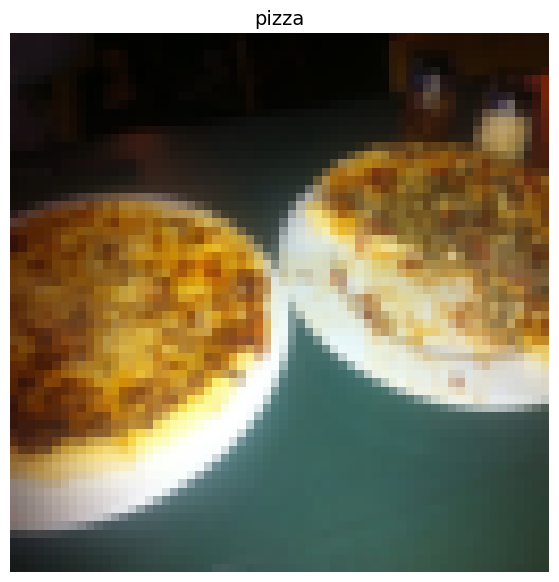

In [24]:
# Plot the image
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0) # (C, H, W) - > (H, W, C)

# Print out different shapes
print(f"Original shape: {img.shape} | New shape: {img_permute.shape}")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [25]:
import os
os.cpu_count()

12

In [26]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x23479fe2ed0>,
 <torch.utils.data.dataloader.DataLoader at 0x23479f8ae90>)

In [27]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [28]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, we can change the batch size if we want
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape} -> [batch_size]")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1]) -> [batch_size]


## 5. Option 2: Loading Image Data with a custom `Dataset`.

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even thought you could create `Dataset` out of almost anything, it doesn't mean it will work...
* More code to write, also it can be prone to performance issues if not done correctly

Custom datasets in PyTorch often subclass `torch.utils.data.Dataset`

In [29]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [30]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a heper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [31]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [32]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
    
    # 3. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of the dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [33]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize
    def __init__(self, targ_dir: str,
                 transform=None):
        # 3. Create attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite the len method
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)
    
    # 6. Overwrite the getitem method
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        return img, class_idx

In [34]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [35]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [36]:
len(train_data), len(train_data_custom)

(225, 225)

In [37]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)!!

In [38]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot 'em.
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust the dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot the samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

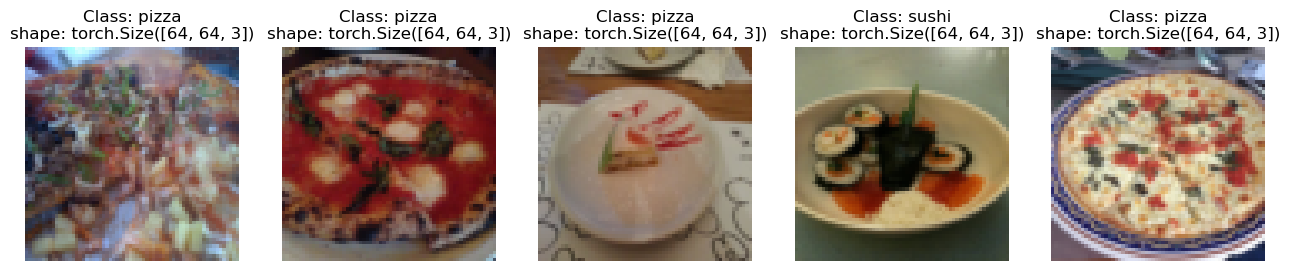

In [39]:
# Display random images form the ImageFolder created Dataset
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=5,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


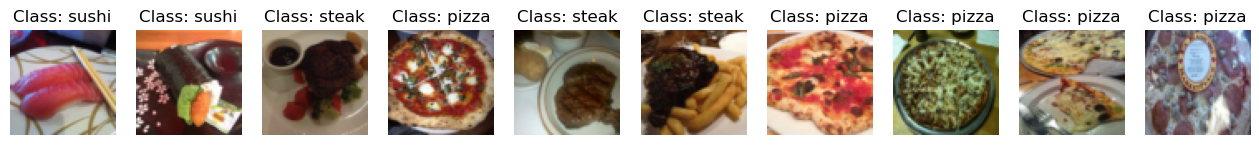

In [40]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`s

In [49]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2347b5c2d10>,
 <torch.utils.data.dataloader.DataLoader at 0x2347b5c35d0>)

In [50]:
# Get sample image and label
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transform (data augmentation)

Data augmentation is the process of artificially adding diversity to the training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [51]:
# Let's look at trivial augment
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 244)),
    transforms.ToTensor()
])

In [52]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

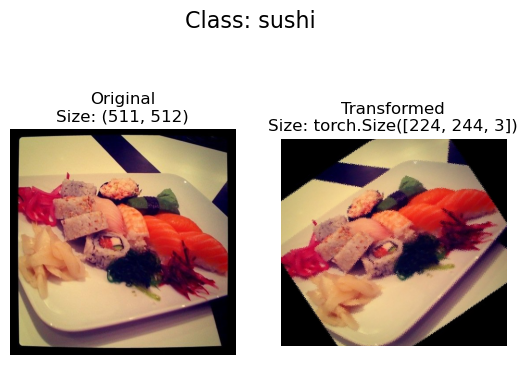

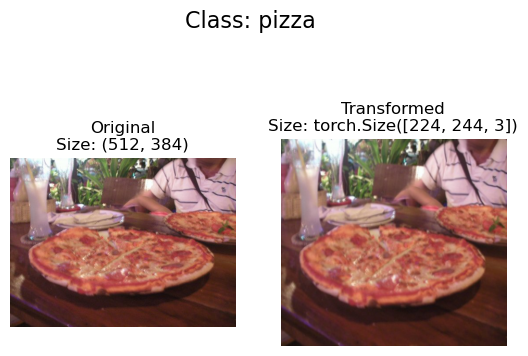

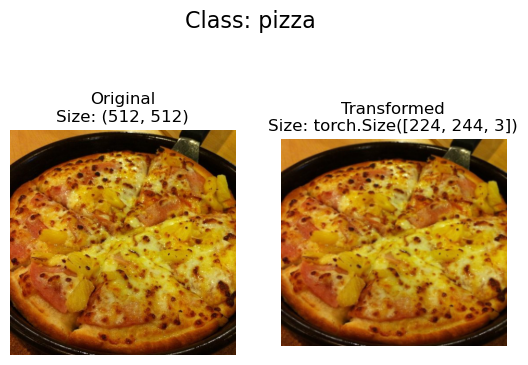

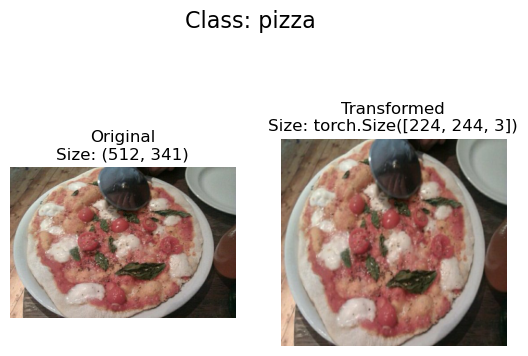

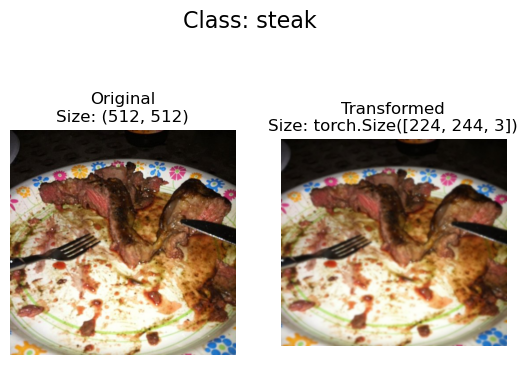

In [55]:
# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=5)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [56]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [58]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [103]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride is same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))  # benefits from operator fusion

In [104]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.4 Try a forward pass on a single image

In [105]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [106]:
# Try a forward pass
model_0.eval()
with torch.inference_mode():
    x = model_0(image_batch.to(device))
x, x.shape

(tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
         [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
         [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
         [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
         [ 1.9930e-02,  6.6315e-04,  1.0779e-02],
         [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
         [ 2.0999e-02,  1.2868e-04,  1.2473e-02],
         [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
         [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
         [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
         [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
         [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
         [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
         [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
         [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
         [ 2.2096e-02, -4.1426e-03,  9.3852e-03],
         [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
         [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
         [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
         [ 1.8298e-02,  1.6306e-03,  8.5499e-03],


### 7.4 Use `torchinfo` to get an idea of the model's architecture

In [102]:
from torchinfo import summary
summary(model=model_0, input_size=[1, 3, 64, 64])

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [107]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):
    
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()


        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate the accuracy and accumulate it
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [108]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device):
    
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [109]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through training and testing data
    for epoch in tqdm(range(1, epochs+1)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


### 7.7 Train and evaluate model 0

In [118]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
HIDDEN_UNITS = 10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=HIDDEN_UNITS,
                  output_shape=len(train_data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

end_time = timer()

model_0_time = end_time - start_time

print(model_0_time)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1063 | Train acc: 0.30 | Test loss: 1.0983 | Test acc: 0.31
Epoch: 2 | Train loss: 1.0995 | Train acc: 0.33 | Test loss: 1.0699 | Test acc: 0.54
Epoch: 3 | Train loss: 1.0863 | Train acc: 0.49 | Test loss: 1.0801 | Test acc: 0.52
Epoch: 4 | Train loss: 1.0825 | Train acc: 0.41 | Test loss: 1.0599 | Test acc: 0.57
Epoch: 5 | Train loss: 1.0629 | Train acc: 0.41 | Test loss: 1.0609 | Test acc: 0.55
7.4007553000119515


In [119]:
model_0_results

{'train_loss': [1.1063431352376938,
  1.0994758754968643,
  1.0863359421491623,
  1.082546979188919,
  1.0628876984119415],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_loss': [1.0983163515726726,
  1.0699025789896648,
  1.0801018079121907,
  1.059883991877238,
  1.0608508189519246],
 'test_acc': [0.31155303030303033,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

### 7.8 Plot the loss curve of model 0

A **loss curve** is a way of tracking the model's progress over time.

In [120]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [127]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary"""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(1, len(results["train_loss"])+1)

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

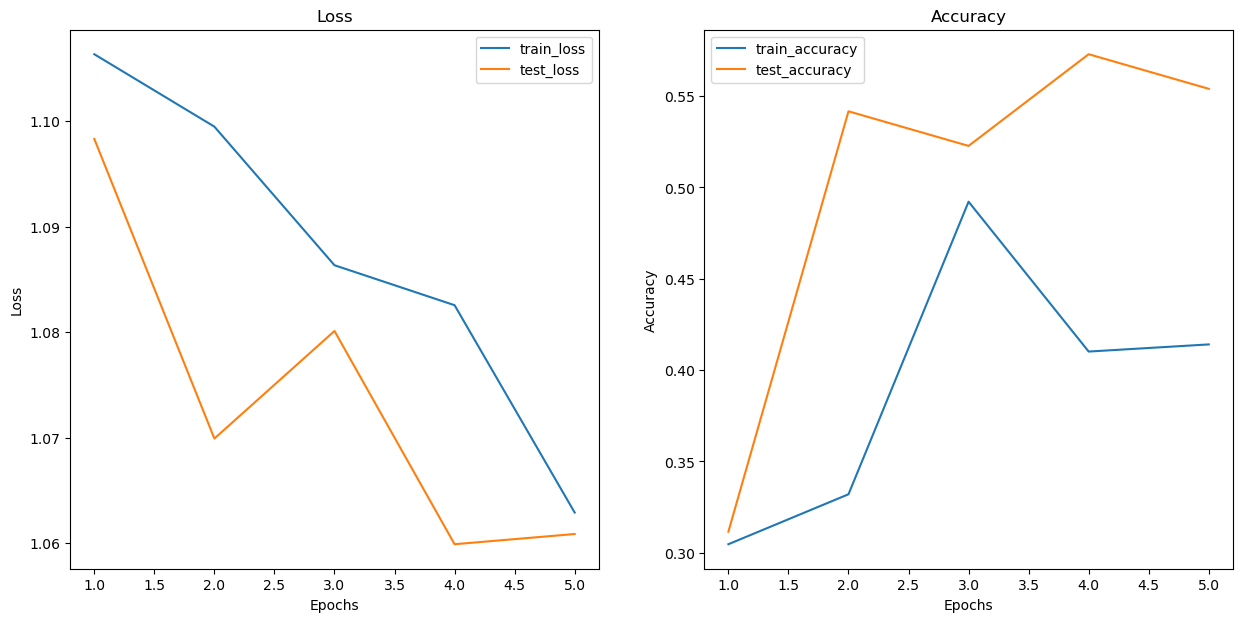

In [128]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most hepful ways to troubleshoot a model.

An ideal loss curve would look like a steep downward slope at the beginning, followed by a gradual downward slope until it levels off.